# AIDI 2000 - Final Project - Group 1

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Paths (UPDATE BASED ON YOUR DIRECTORY)
TRAIN_DIR = r"C:\Users\SriniShru\Downloads\archive (6)\dataset2-master\dataset2-master\images\TRAIN"
TEST_DIR = r"C:\Users\SriniShru\Downloads\archive (6)\dataset2-master\dataset2-master\images\TEST"

IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 20
FINE_TUNE_EPOCHS = 5

# === Data Generators
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# === Label mappings
class_indices = train_gen.class_indices
reverse_class_indices = {v: k for k, v in class_indices.items()}
NUM_CLASSES = len(class_indices)

# === Build DenseNet121 Model
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

# === Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, min_lr=1e-6)

# === Training
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=EPOCHS,
    callbacks=[early_stop, reduce_lr]
)

# === Fine-tuning
base_model.trainable = True
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=FINE_TUNE_EPOCHS,
    callbacks=[early_stop, reduce_lr]
)




Found 2204 images belonging to 4 classes.
Found 71 images belonging to 4 classes.
Epoch 1/20
69/69 [==============================] - 83s 1s/step - loss: 1.6288 - accuracy: 0.3734 - val_loss: 1.3244 - val_accuracy: 0.4789 - lr: 1.0000e-04
Epoch 2/20
69/69 [==============================] - 84s 1s/step - loss: 1.2054 - accuracy: 0.5195 - val_loss: 1.2052 - val_accuracy: 0.5352 - lr: 1.0000e-04
Epoch 3/20
69/69 [==============================] - 83s 1s/step - loss: 1.0650 - accuracy: 0.5835 - val_loss: 1.1524 - val_accuracy: 0.5634 - lr: 1.0000e-04
Epoch 4/20
69/69 [==============================] - 87s 1s/step - loss: 0.9348 - accuracy: 0.6357 - val_loss: 1.1054 - val_accuracy: 0.5915 - lr: 1.0000e-04
Epoch 5/20
69/69 [==============================] - 83s 1s/step - loss: 0.8562 - accuracy: 0.6720 - val_loss: 1.0678 - val_accuracy: 0.6056 - lr: 1.0000e-04
Epoch 6/20
69/69 [==============================] - 83s 1s/step - loss: 0.8080 - accuracy: 0.6869 - val_loss: 1.0423 - val_accuracy: 

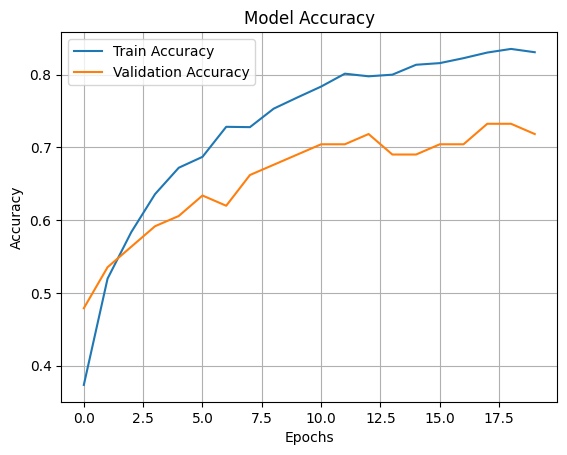

In [3]:
# === Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()



In [4]:
# === Evaluation
y_true = test_gen.classes
y_pred_probs = model.predict(test_gen)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(class_indices.keys())))



3/3 [==============================] - 4s 644ms/step

Classification Report:

              precision    recall  f1-score   support

  EOSINOPHIL       0.83      0.77      0.80        13
  LYMPHOCYTE       0.71      0.83      0.77         6
    MONOCYTE       1.00      0.75      0.86         4
  NEUTROPHIL       0.90      0.92      0.91        48

    accuracy                           0.87        71
   macro avg       0.86      0.82      0.83        71
weighted avg       0.88      0.87      0.87        71



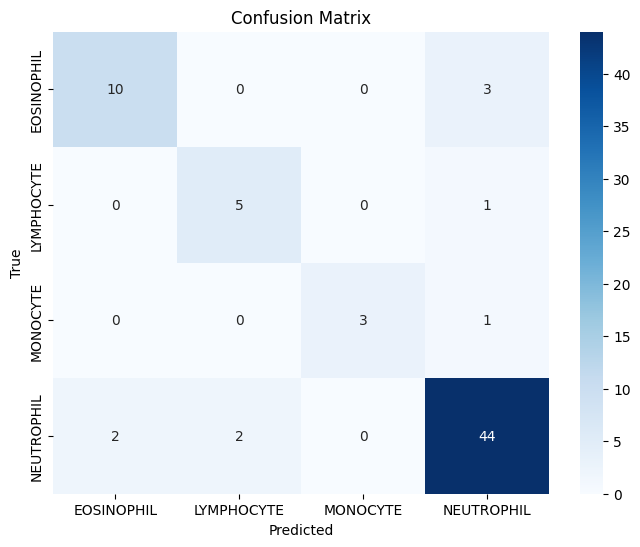

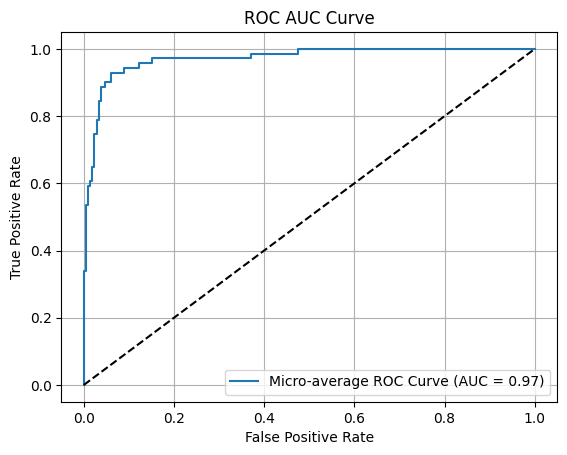

✅ Final model saved as model_bccd.h5


In [5]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_indices.keys(), yticklabels=class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# ROC AUC (Micro)
fpr, tpr, _ = roc_curve(tf.keras.utils.to_categorical(y_true).ravel(), y_pred_probs.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f"Micro-average ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC AUC Curve")
plt.legend()
plt.grid(True)
plt.show()

# === Save Model
model.save("model_bccd.h5")
print("✅ Final model saved as model_bccd.h5")